In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib as plt

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# import betting lines and that to top of sheet
import requests

source = requests.get("https://www.bovada.lv/services/sports/event/v2/events/A/description/soccer/germany-bundesliga").json()

data = source[0]

In [4]:
# returns a list of a list of dictionaries with betting info for all games with spreads on bovada
def get_matchup_betting_info(data):
    betting_info = list()
    games = data['events'][:-1]
    for game in games:
        single_game = list()
        game_info = game['displayGroups'][0]['markets'][0]['outcomes']
        total_info = game['displayGroups'][0]['markets'][1]['outcomes']
        ml_info = game['displayGroups'][0]['markets'][2]['outcomes']
        for team in game_info:
            temp = {}
            temp['team'] = team['description']
            temp['spread'] = team['price']['handicap']
            double_spread = team['price'].get('handicap2', None)
            if double_spread:
                temp['spread2'] = double_spread
            temp['odds'] = team['price']['american']
            single_game.append(temp)
        for result in total_info:
            temp = {}
            temp['type'] = result['description']
            temp['total'] = result['price']['handicap']
            multi_total = result['price'].get('handicap2', None)
            if multi_total:
                temp['total2'] = multi_total
            temp['odds'] = result['price']['american']
            single_game.append(temp)
        for result in ml_info:
            temp = {}
            temp['team'] = result['description']
            temp['ml_odds'] = result['price']['american']
            single_game.append(temp)
        betting_info.append(single_game)
    return betting_info

In [5]:
betting_info =get_matchup_betting_info(data)

In [6]:
team_names = list()
for game in betting_info:
    for row in game:
        if row.get('team', None):
            team_names.append(row['team'])
team_names = set(team_names)
team_names = sorted(list(team_names))

In [9]:
team_names
#team_names.remove('Sport-Club Freiburg')

['1. FC Köln',
 'Augsburg',
 'Bayer Leverkusen',
 'Bayern Munich',
 'Borussia Dortmund',
 'Borussia Monchengladbach',
 'Draw',
 'Eintracht Frankfurt',
 'FC Schalke 04',
 'FSV Mainz',
 'Freiburg',
 'Hertha Berlin',
 'Hoffenheim',
 'Paderborn',
 'RB Leipzig',
 'SV Werder Bremen',
 'Union Berlin',
 'VfL Wolfsburg']

In [11]:
stats = pd.read_csv('data/D1.csv')

In [12]:
stats['Date'] = pd.to_datetime(stats['Date'], infer_datetime_format=True)

In [13]:
tables = pd.read_html('https://fbref.com/en/comps/20/Bundesliga-Stats')

In [14]:
form_df = tables[0]

In [15]:
xg_df = tables[1]

In [16]:
narrow_stats = stats.iloc[:, :23]

In [17]:
narrow_stats['HTHD'] = narrow_stats['HTHG'] - narrow_stats['HTAG']

In [18]:
narrow_stats['FTHD'] = narrow_stats['FTHG'] - narrow_stats['FTAG']

In [19]:
narrow_stats['HTAD'] = narrow_stats['HTAG'] - narrow_stats['HTHG']
narrow_stats['FTAD'] = narrow_stats['FTAG'] - narrow_stats['FTHG']

In [20]:
narrow_stats['HTT'] = narrow_stats['HTHG'] + narrow_stats['HTAG']
narrow_stats['FTT'] = narrow_stats['FTHG'] + narrow_stats['FTAG']

In [21]:
# fix discrepancy between dataframe team names
narrow_stats = narrow_stats.replace('Hertha', 'Hertha Berlin')
narrow_stats = narrow_stats.replace('Leverkusen', 'Bayer Leverkusen')
narrow_stats = narrow_stats.replace('Dortmund','Borussia Dortmund' )
narrow_stats = narrow_stats.replace('Schalke 04', 'FC Schalke 04')
narrow_stats = narrow_stats.replace("M'gladbach", 'Borussia Monchengladbach')
narrow_stats = narrow_stats.replace( 'Ein Frankfurt', 'Eintracht Frankfurt')
narrow_stats = narrow_stats.replace( 'Mainz', 'FSV Mainz')
narrow_stats = narrow_stats.replace( 'Werder Bremen', 'SV Werder Bremen')
narrow_stats = narrow_stats.replace( 'Wolfsburg', 'VfL Wolfsburg')
narrow_stats = narrow_stats.replace( 'FC Koln', '1. FC Köln')

In [22]:
# add shots, shots on target, fouls, cards, corners, corners given up
teams_df = pd.DataFrame()
teams_df['team'] = list(narrow_stats['HomeTeam'].unique())
teams_df = teams_df.set_index('team')

In [23]:
home_averages = narrow_stats.groupby('HomeTeam').mean()

In [24]:
away_averages = narrow_stats.groupby('AwayTeam').mean()

In [25]:
home_teams_df = teams_df.merge(home_averages, left_index=True, right_index=True)

In [26]:
home_teams_df = home_teams_df.drop(['HF', 'AF', 'HR', 'AR', 'FTAD', 'HTAD'], axis=1)

In [27]:
home_teams_df.columns = ['Goals', 'Goals Against', 'Half Time Goals', 'Half Time Goals Against', 'Shots For', \
                    'Shots Against', 'Shots on Target', 'Shots on Target Allowed', 'Corners', 'Corners Allowed', \
                    'Yellows', 'Opponent Yellows', 'Half Time Differential', 'Full Time Differential', 'Half Time Total', \
                    'Full Time Total']

In [28]:
# standardize team names for xg_df
xg_df = xg_df.replace('Hertha BSC', 'Hertha Berlin')
xg_df = xg_df.replace('Leverkusen', 'Bayer Leverkusen')
xg_df = xg_df.replace('Dortmund','Borussia Dortmund' )
xg_df = xg_df.replace('Schalke 04', 'FC Schalke 04')
xg_df = xg_df.replace("M'gladbach", 'Borussia Monchengladbach')
xg_df = xg_df.replace( 'Eint Frankfurt', 'Eintracht Frankfurt')
xg_df = xg_df.replace( 'Mainz 05', 'FSV Mainz')
xg_df = xg_df.replace( 'Werder Bremen', 'SV Werder Bremen')
xg_df = xg_df.replace( 'Wolfsburg', 'VfL Wolfsburg')
xg_df = xg_df.replace( 'Köln', '1. FC Köln')
xg_df = xg_df.replace( 'Paderborn 07', 'Paderborn')
xg_df = xg_df.replace('Düsseldorf','Fortuna Dusseldorf' )

In [29]:
# standardize team names for form
form_df = form_df.replace('Hertha BSC', 'Hertha Berlin')
form_df = form_df.replace('Leverkusen', 'Bayer Leverkusen')
form_df = form_df.replace('Dortmund','Borussia Dortmund' )
form_df = form_df.replace('Schalke 04', 'FC Schalke 04')
form_df = form_df.replace("M'gladbach", 'Borussia Monchengladbach')
form_df = form_df.replace( 'Eint Frankfurt', 'Eintracht Frankfurt')
form_df = form_df.replace( 'Mainz 05', 'FSV Mainz')
form_df = form_df.replace( 'Werder Bremen', 'SV Werder Bremen')
form_df = form_df.replace( 'Wolfsburg', 'VfL Wolfsburg')
form_df = form_df.replace( 'Köln', '1. FC Köln')
form_df = form_df.replace('Düsseldorf','Fortuna Dusseldorf' )
form_df = form_df.replace( 'Paderborn 07', 'Paderborn')

In [30]:
# get home teams df and standardize team names
home_teams_df = home_teams_df.reset_index().sort_values('index')
home_teams_df = home_teams_df.set_index('index')

In [31]:
away_teams_df = teams_df.merge(away_averages, left_index=True, right_index=True)

In [32]:
away_teams_df = away_teams_df.drop(['HF', 'AF', 'HR', 'AR', 'FTHD', 'HTHD'], axis=1)

In [33]:
away_teams_df.columns = ['Goals Against', 'Goals', 'Half Time Goals Against', 'Half Time Goals', 'Shots Against', 'Shots For', \
                         'Shots on Target Allowed', 'Shots on Target', 'Corners Allowed', 'Corners', 'Opponent Yellows', 'Yellows', \
                         'Half Time Differential', 'Full Time Differential', 'Half Time Total', 'Full Time Total']

In [34]:
away_teams_df = away_teams_df.reset_index().sort_values('index')
away_teams_df = away_teams_df.set_index('index')

In [35]:
# team spellings to plug in
sorted(team_names)

['1. FC Köln',
 'Augsburg',
 'Bayer Leverkusen',
 'Bayern Munich',
 'Borussia Dortmund',
 'Borussia Monchengladbach',
 'Draw',
 'Eintracht Frankfurt',
 'FC Schalke 04',
 'FSV Mainz',
 'Freiburg',
 'Hertha Berlin',
 'Hoffenheim',
 'Paderborn',
 'RB Leipzig',
 'SV Werder Bremen',
 'Union Berlin',
 'VfL Wolfsburg']

In [52]:
# in Bovada Home team is on top and away team is on bottom
from game_preview import game_preview
home =  'SV Werder Bremen'
away = 'Bayer Leverkusen'

In [53]:
gp = game_preview(home, away, home_teams_df, away_teams_df, form_df, xg_df, narrow_stats, betting_info)

In [54]:
print(gp)

Game Preview of Bayer Leverkusen at SV Werder Bremen


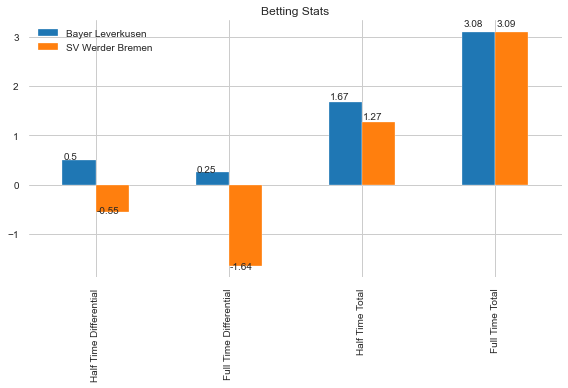

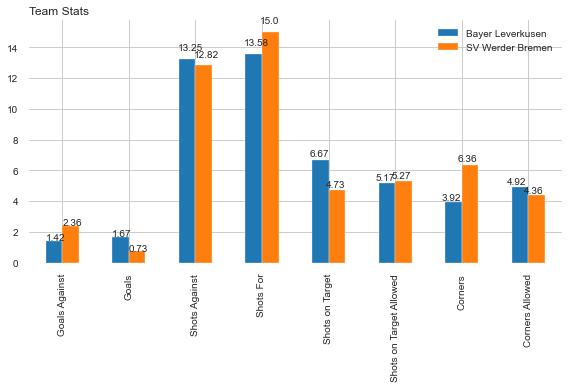

In [55]:
gp.get_preview()